# Synthetic Validation of Accuracy-Fidelity Theory

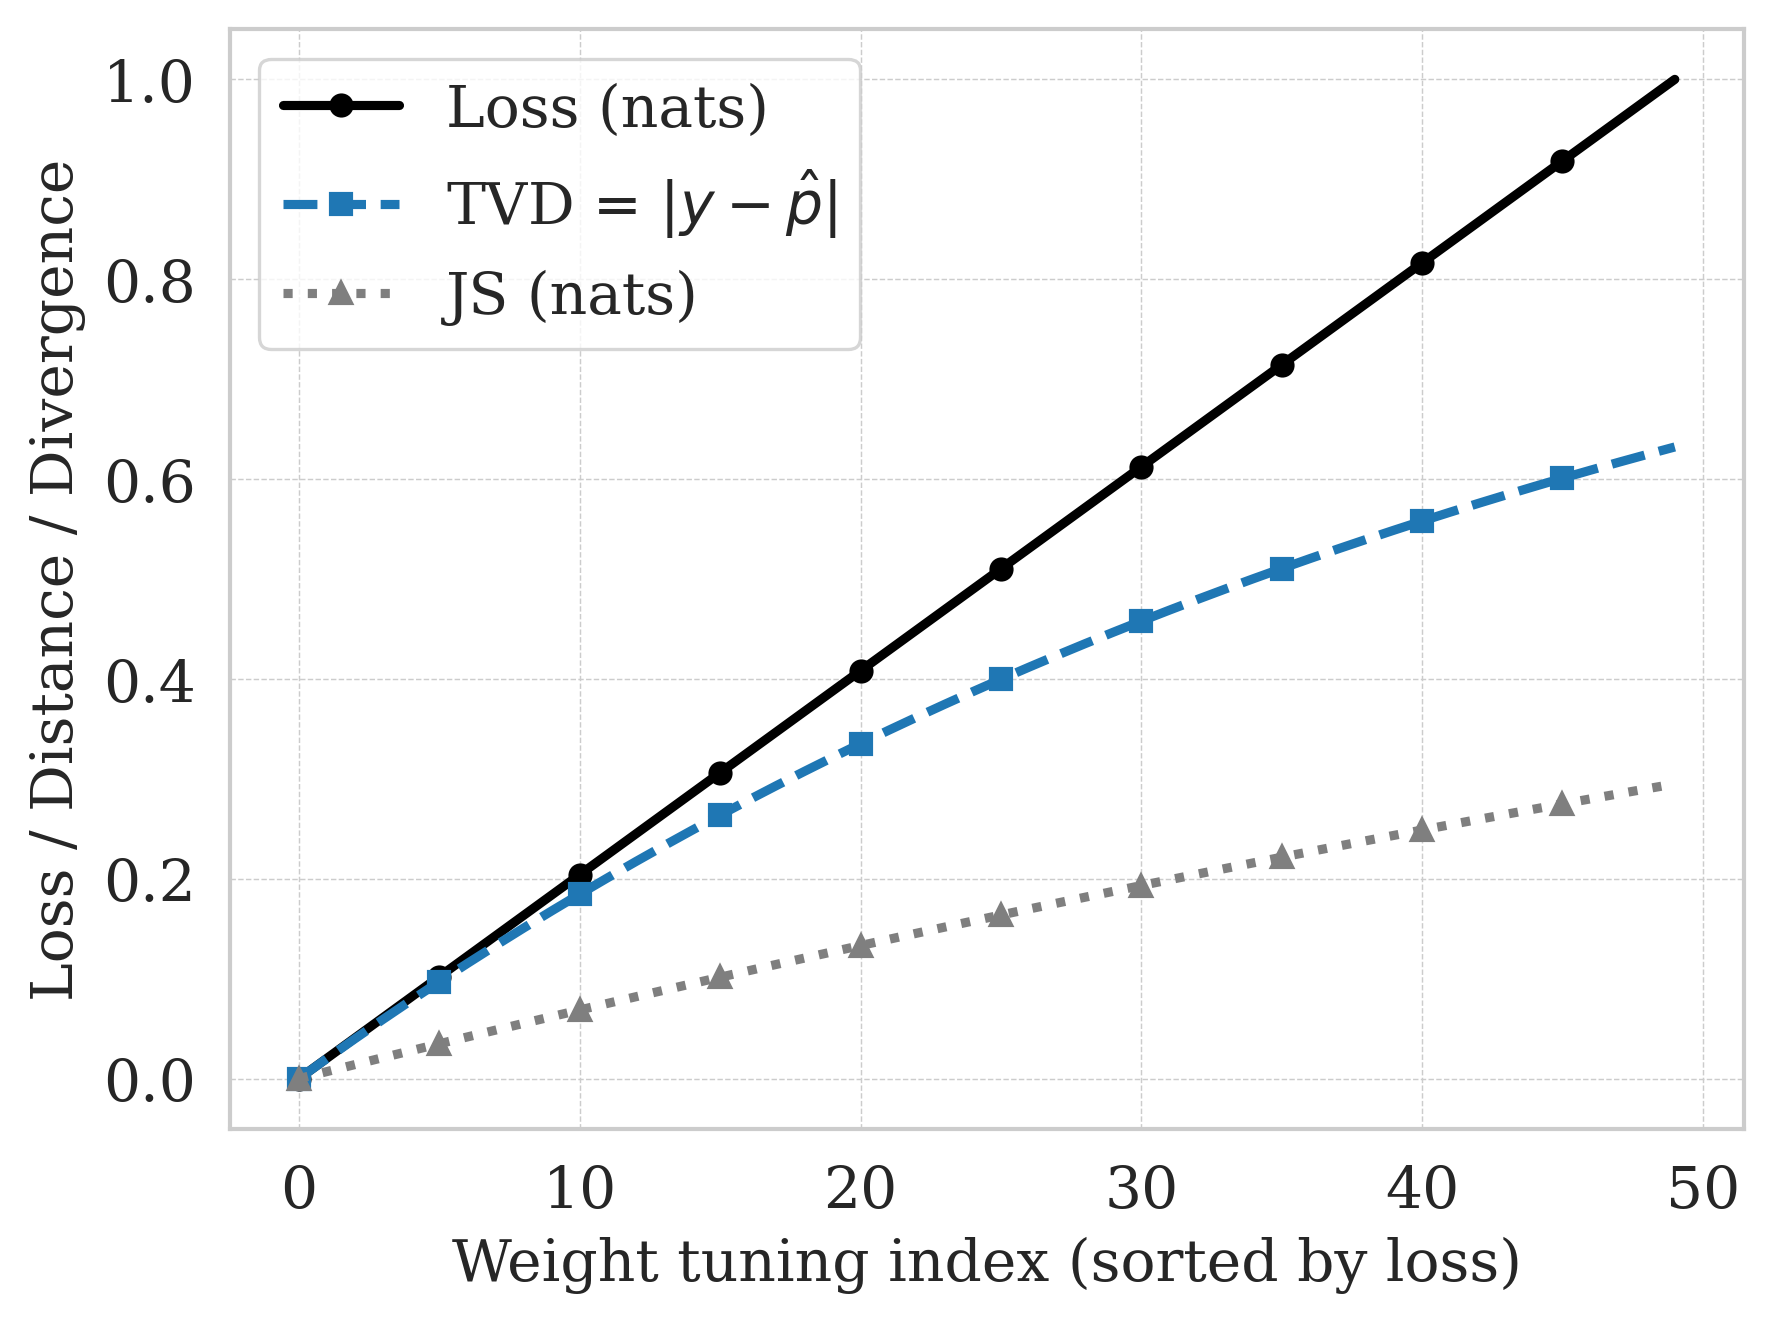

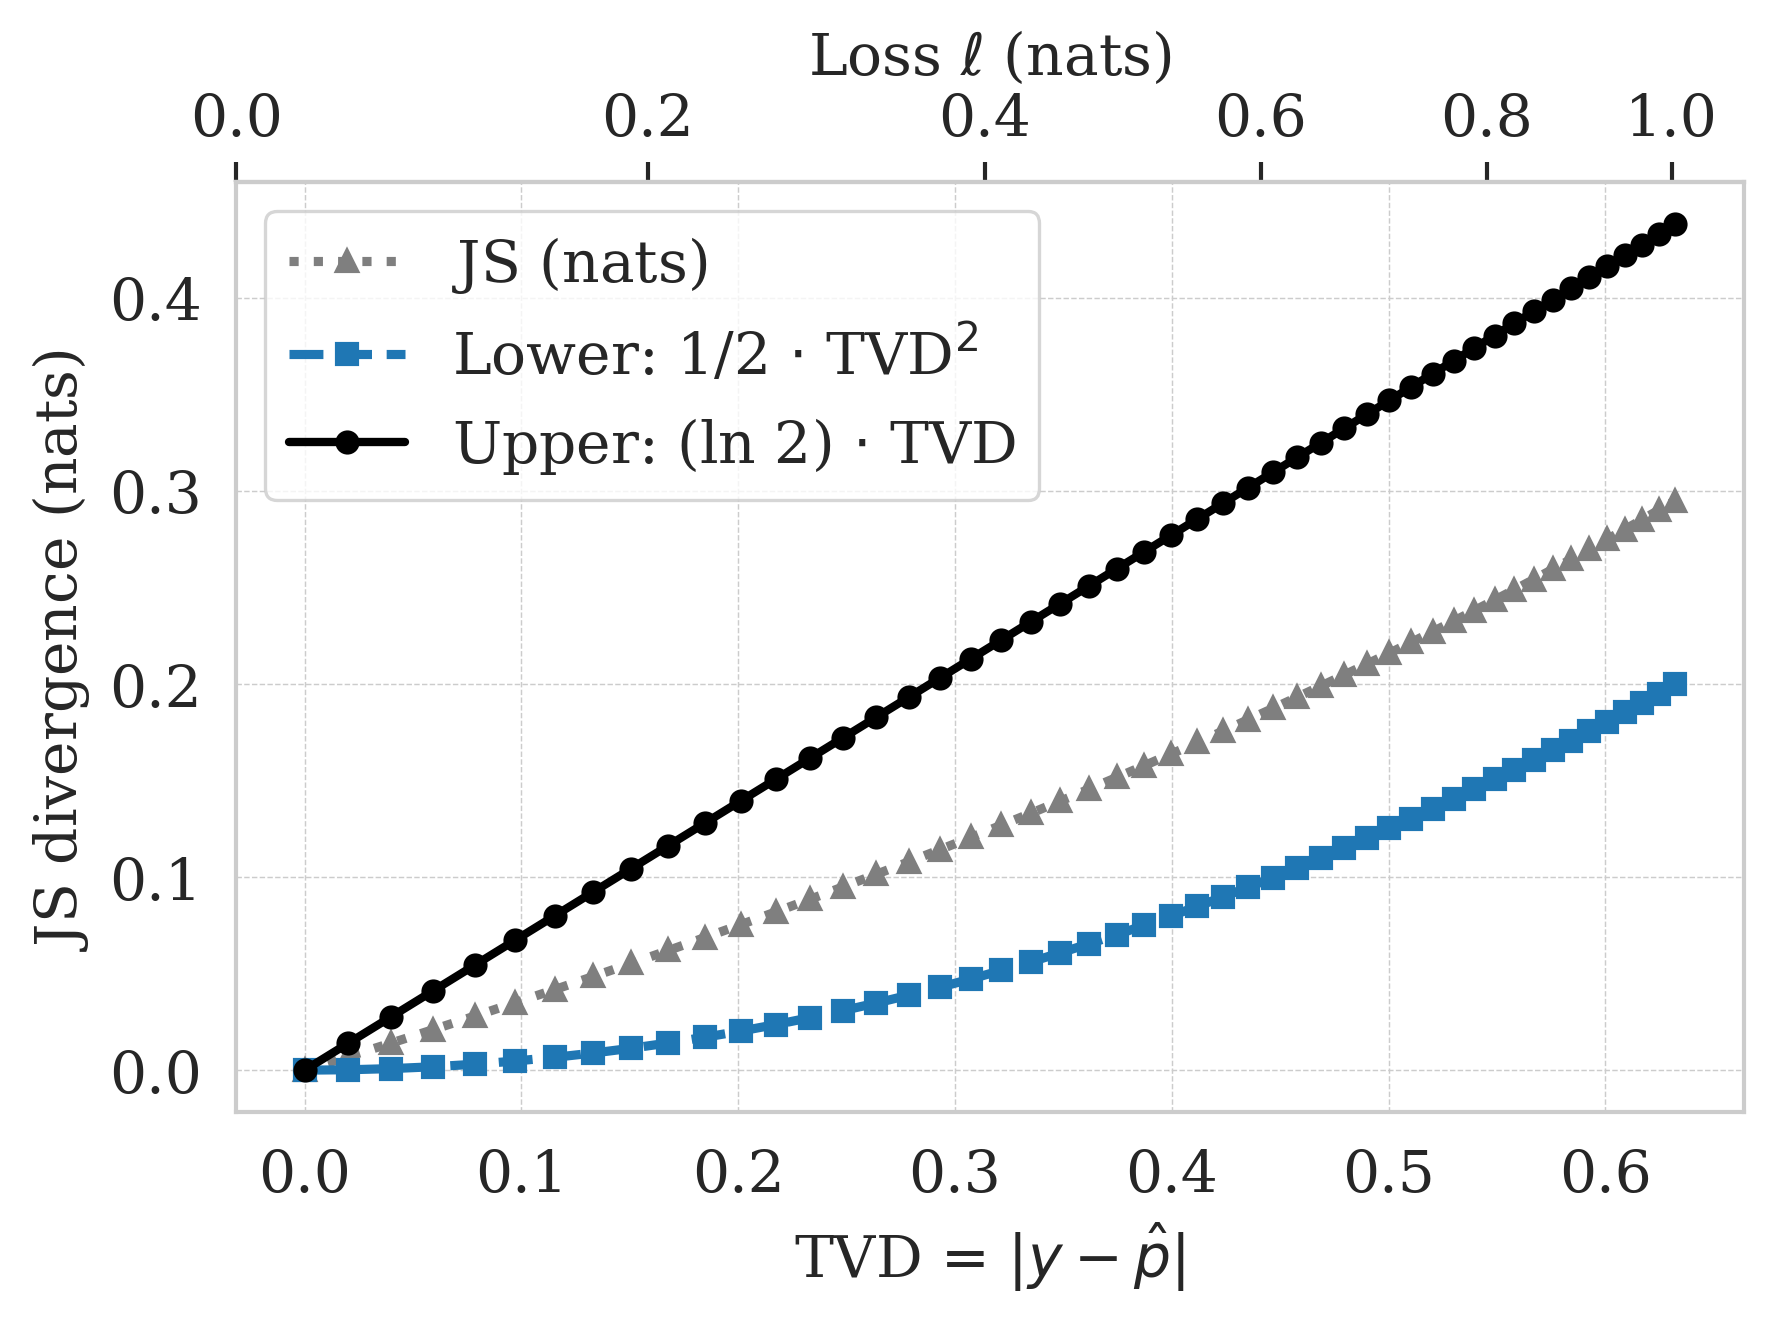

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Style and font setup for PDF output
sns.set(style="whitegrid", context="paper")
rcParams['pdf.use14corefonts'] = True
plt.rc('font', family='serif')

fsize = 14

# Data used to construct the feature vector
row = {
    "label": 1,
    "min": 9.090658,
    "max": 495.041767,
    "alpha": 3.277064,
    "beta": 4.038462,
    "mean_true": 226.777371,
    "median_true": 224.241714,
    "mean_obs": 223.975725,
    "median_obs": 220.255929,
    "alpha_est": 2.520988,
    "beta_est": 3.180092,
}

# Binary label
y = 1 if row["label"] == 2 else 0

# Intercept-padded feature vector
x = np.array([
    1.0,
    row["mean_obs"],
    row["median_obs"],
    row["min"],
    row["max"],
    row["alpha_est"],
    row["beta_est"],
], dtype=float)

def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + np.exp(-z))

# Binary entropy in nats
def H(u: np.ndarray) -> np.ndarray:
    u = np.clip(u, 1e-15, 1 - 1e-15)
    return -u * np.log(u) - (1 - u) * np.log(1 - u)

# JS divergence (Bernoulli p vs. 1/2) in nats
def js_from_py(py: np.ndarray) -> np.ndarray:
    m = 0.5 * (1.0 + py)
    return H(m) - 0.5 * H(py)

# Unit direction and scaling for weight search
x_norm = np.linalg.norm(x)
u = x / (x_norm if x_norm != 0 else 1.0)
s = float(u @ x)

# Target per-example losses used to back out probabilities and logits
k = 50
loss_target = np.linspace(0.0, 1.0, k)

# Collect per-example loss, TVD, and JS across the weight tuning sweep
records = []
for ell in loss_target:
    p_y = np.exp(-ell)
    p_hat = p_y if y == 1 else 1.0 - p_y
    p_hat = np.clip(p_hat, 1e-12, 1 - 1e-12)
    z = np.log(p_hat / (1.0 - p_hat))
    lam = z / (s if s != 0 else 1.0)
    w = lam * u
    p_pred = sigmoid(float(w @ x))
    p_trueclass = p_pred if y == 1 else 1.0 - p_pred
    ell_check = -np.log(np.clip(p_trueclass, 1e-12, 1.0))
    tvd_label = abs(y - p_pred)
    js_label  = js_from_py(np.array([p_trueclass]))[0]
    records.append((ell_check, tvd_label, js_label))

loss, tvd, js = map(np.array, zip(*sorted(records, key=lambda r: r[0])))

# ==========================================================
#   FIGURE 1 — Per-example Loss, TVD, and JS
#   (colors unchanged; add styles/markers for B/W readability)
# ==========================================================
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)

mark_every = max(1, len(loss)//10)
COL_BLACK = "#000000"
COL_BLUE  = "#1f77b4"
COL_GREY  = "#7f7f7f"

ax.plot(range(len(loss)), loss, linewidth=2.2, color=COL_BLACK,
        linestyle='-',  marker='o', markevery=mark_every, label="Loss (nats)")
ax.plot(range(len(tvd)),  tvd,  linewidth=2.2, color=COL_BLUE,
        linestyle='--', marker='s', markevery=mark_every, label=r"TVD = $|y - \hat{p}|$")
ax.plot(range(len(js)),   js,   linewidth=2.2, color=COL_GREY,
        linestyle=':',  marker='^', markevery=mark_every, label="JS (nats)")

ax.set_xlabel("Weight tuning index (sorted by loss)", fontsize=fsize)
ax.set_ylabel("Loss / Distance / Divergence", fontsize=fsize)

ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)

ax.legend(fontsize=fsize, loc='upper left', facecolor='white', frameon=True)

plt.tight_layout()
plt.savefig('per_example_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
#plt.show()

# ==========================================================
#   FIGURE 2 — JS vs TVD Quadratic Bound
#   (colors unchanged; add styles/markers for B/W readability)
# ==========================================================
lb = 0.5 * tvd**2
ub = (np.log(2.0)) * tvd

# Mapping functions for the secondary x-axis
def tvd_to_loss(t):
    t = np.clip(t, 1e-12, 1 - 1e-12)
    return -np.log(1.0 - t)

def loss_to_tvd(l):
    l = np.maximum(l, 0.0)
    return 1.0 - np.exp(-l)

fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)

ax.plot(tvd, js, color=COL_GREY, linestyle=':',  marker='^', linewidth=2.2, label=r"JS (nats) ${}$")
ax.plot(tvd, lb, color=COL_BLUE, linestyle='--', marker='s', linewidth=2.2, label=r"Lower: 1/2 $\cdot$ TVD$^2$")
ax.plot(tvd, ub, color=COL_BLACK, linestyle='-',  marker='o', linewidth=2.0, label=r"Upper: (ln 2) $\cdot$ TVD")

ax.set_xlabel(r"TVD = $|y - \hat{p}|$", fontsize=fsize)
ax.set_ylabel(r"JS divergence (nats) ${}$", fontsize=fsize)

secax = ax.secondary_xaxis('top', functions=(tvd_to_loss, loss_to_tvd))
secax.set_xlabel(r"Loss $\ell$ (nats)", fontsize=fsize)
secax.tick_params(axis='x', labelsize=fsize)
secax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)

ax.legend(fontsize=fsize, loc='upper left', facecolor='white', frameon=True)

plt.tight_layout()
plt.savefig('quadratic_bound.pdf', format='pdf', dpi=300, bbox_inches='tight')
#plt.show()


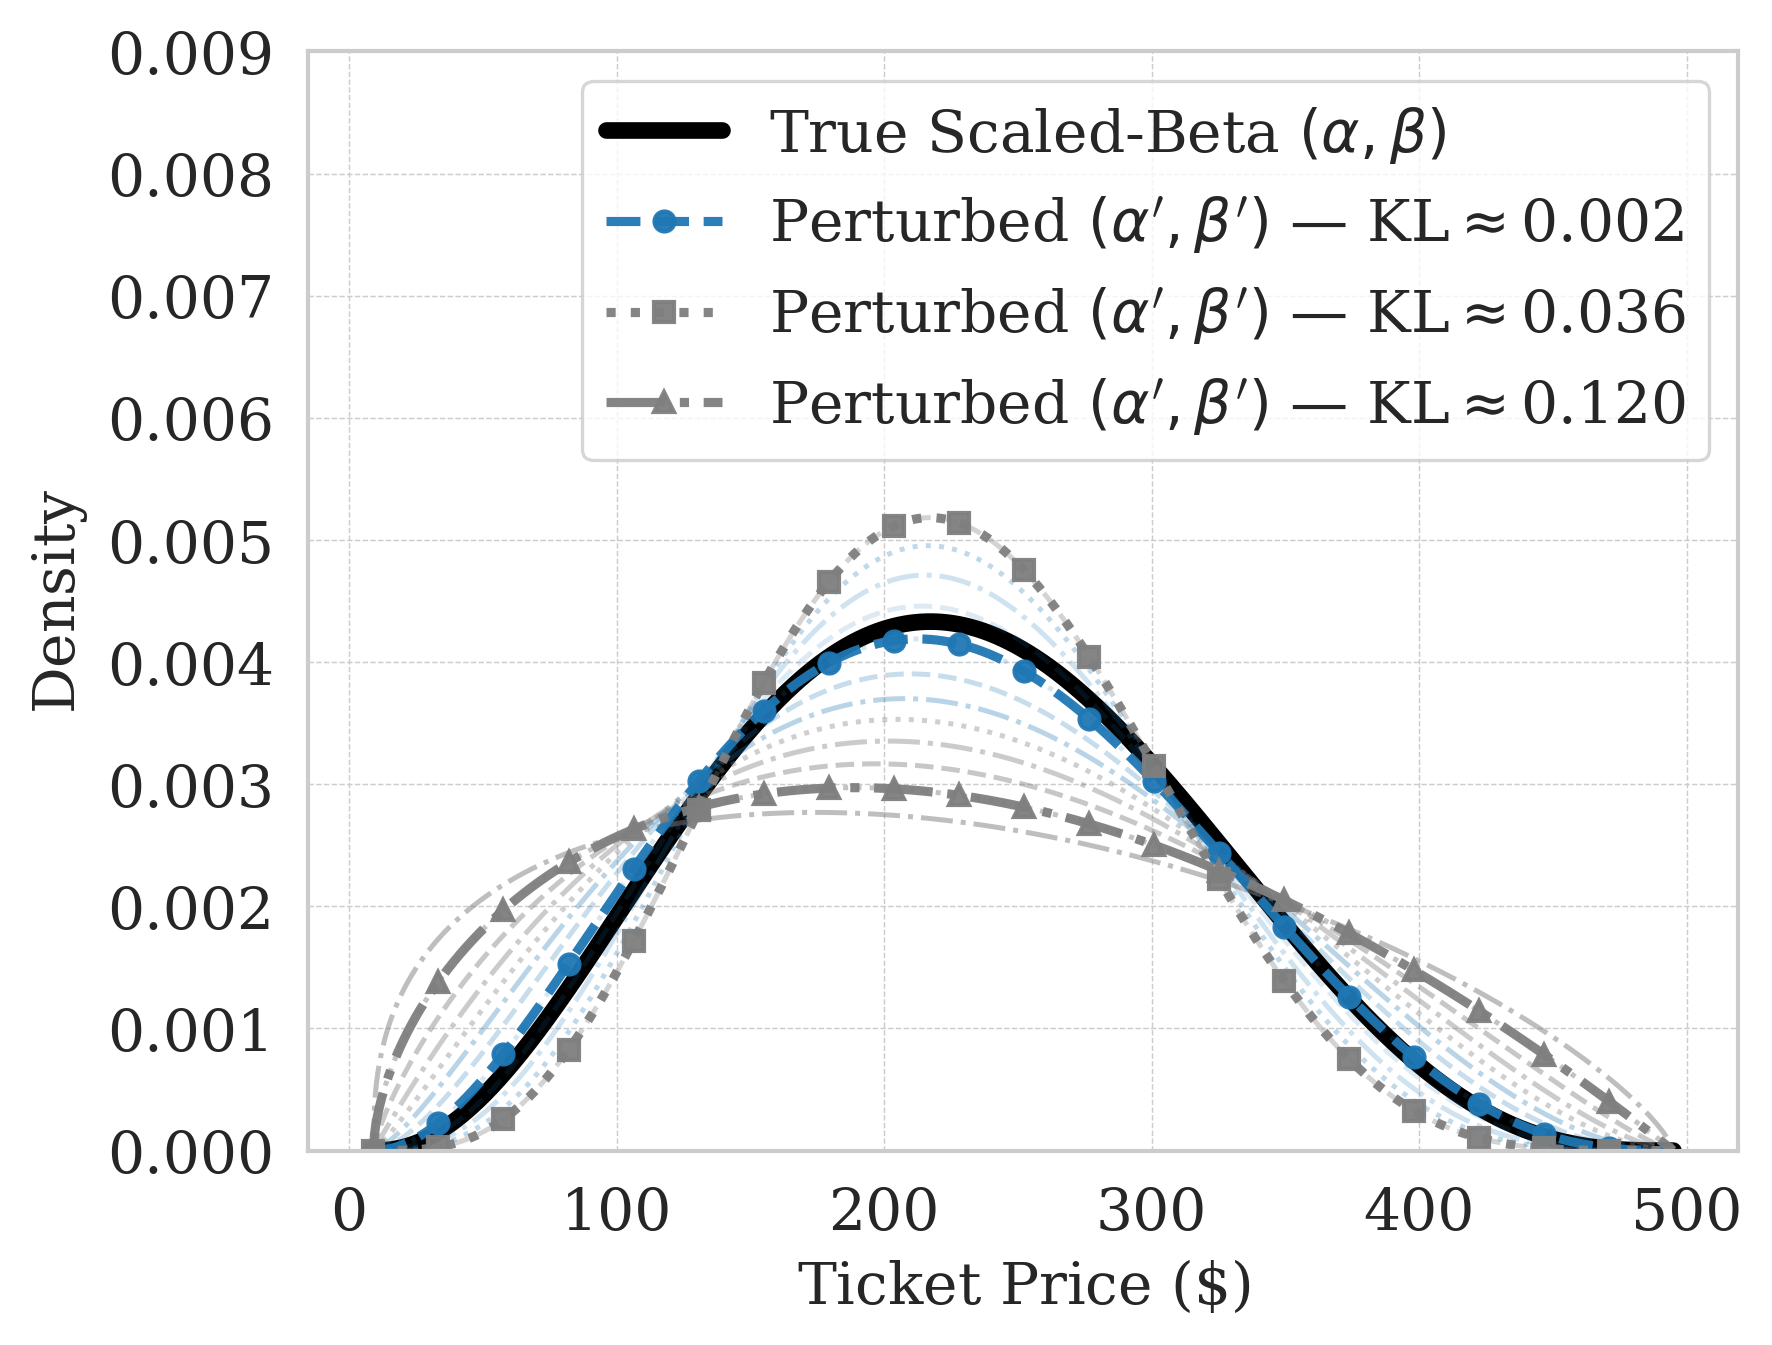

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.special import betaln, digamma

# ----- Example row -----
row = {
    "label": 1,
    "min": 9.090658,
    "max": 495.041767,
    "alpha": 3.277064,
    "beta": 4.038462,
    "alpha_est": 2.520988,
    "beta_est": 3.180092,
}
lo = float(row["min"]); hi = float(row["max"])
a_true, b_true = float(row["alpha"]), float(row["beta"])
a_est0, b_est0 = float(row["alpha_est"]), float(row["beta_est"])

# ----- Scaled-Beta pdf on [lo, hi] -----
def beta_pdf_unit(t, a, b):
    t = np.clip(t, 1e-12, 1 - 1e-12)
    return np.exp((a - 1) * np.log(t) + (b - 1) * np.log(1 - t) - betaln(a, b))

def scaled_beta_pdf(x, a, b, lo, hi):
    t = (x - lo) / (hi - lo)
    return beta_pdf_unit(t, a, b) / (hi - lo)

# ----- KL for Beta(a,b) || Beta(c,d) (support scaling invariant) -----
def kl_beta(a, b, c, d):
    term1 = betaln(c, d) - betaln(a, b)
    term2 = (a - c) * (digamma(a) - digamma(a + b))
    term3 = (b - d) * (digamma(b) - digamma(a + b))
    return float(term1 + term2 + term3)

# ----- Build perturbations around (a_est0, b_est0) and sort by KL -----
rng = np.random.default_rng(7)
scales = np.concatenate([
    np.linspace(0.55, 0.95, 6),
    np.linspace(1.05, 1.80, 6),
])
pairs = []
for r in scales:
    a_p = a_est0 * r
    b_p = b_est0 * r
    KL = kl_beta(a_true, b_true, a_p, b_p)
    pairs.append((KL, a_p, b_p))
pairs.sort(key=lambda t: t[0])  # increasing divergence

# Representative curves and x-grid
idx_key = [1, len(pairs)//2, len(pairs)-2]
x = np.linspace(lo, hi, 1200)

# --- Style template ---
sns.set(style="whitegrid", context="paper")
rcParams['pdf.use14corefonts'] = True
plt.rc('font', family='serif')

fsize = 14

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)

# True density (solid black, bold)
p_true = scaled_beta_pdf(x, a_true, b_true, lo, hi)
ax.plot(x, p_true, color="black", linewidth=4, linestyle='-',
        label=r"True Scaled-Beta $(\alpha,\beta)$")

# Light cloud of perturbations (original colors; add linestyle cycle for B/W)
linestyles = ['--', ':', '-.']
for j, (KL, a_p, b_p) in enumerate(pairs):
    color = "#1f77b4" if j < len(pairs)//2 else "#7f7f7f"  # unchanged colors
    alpha = 0.15 + 0.35 * (j / (len(pairs)-1))             # opacity increases with divergence
    ls = linestyles[j % len(linestyles)]
    lw = 1.2
    p = scaled_beta_pdf(x, a_p, b_p, lo, hi)
    ax.plot(x, p, color=color, alpha=alpha, linewidth=lw, linestyle=ls)

# Emphasize a few representative perturbations (unchanged colors; add markers/linestyles)
key_linestyles = ['--', ':', '-.']
key_markers    = ['o', 's', '^']
for k, j in enumerate(idx_key):
    KL, a_p, b_p = pairs[j]
    color = "#1f77b4" if j < len(pairs)//2 else "#7f7f7f"
    lbl = fr"Perturbed $(\alpha',\beta')$ — KL$\approx${KL:.3f}"
    p = scaled_beta_pdf(x, a_p, b_p, lo, hi)
    ax.plot(x, p, color=color, linewidth=2.2, alpha=0.95,
            linestyle=key_linestyles[k % len(key_linestyles)],
            marker=key_markers[k % len(key_markers)], markevery=60, label=lbl)

# --- Formatting ---
ax.set_xlabel(r"Ticket Price (\$)${}$", fontsize=fsize)
ax.set_ylabel(r"Density${}$", fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.set_ylim(0, .009)
ax.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)
ax.legend(fontsize=fsize, loc='upper right', facecolor='white', frameon=True)

plt.tight_layout()
plt.savefig(
    'beta_perturbed.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight'
)
#plt.show()
